# Hurricane Path Predictor
A model that predicts hurricane landfall locations. The US National Hurricane Center provides this information from 1851 to 2016 in the HURDAT2 dataset.

![alt text](map.png)

<center>(Figure 1) Hurricane landfall zones</center>

### Importing the Data

In [3]:
# Import python modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Read .csv file line-by-line
with open('hurdat2-1851-2016-041117.csv', 'r') as f: 
       file_data = [row.strip().split(',') for row in f]
# Convert data file to data frame
df = pd.DataFrame(file_data)

### Cleaning the Data

In [5]:
# Delete columns with missing or incomplete data
df.drop([2] + list(range(7,21)), axis='columns', inplace=True)
# Renaming columns
data = pd.DataFrame(np.matrix(df),
                    columns=['date', 'time', 'status', 'lat', 'lon', 'max_wind'])

In [6]:
# Encoding new events
def time_convert(time_str):
    try:
        return(int(time_str.strip()))
    except:
        pass
data.date = data.date.apply(lambda x: '99999999' if x[0] == 'A' else x.strip())
data.time = data.time.apply(lambda x: x.strip())
data.status = data.status.apply(lambda x: 'NE' if x == '' else x.strip())
data.lat = data.lat.apply(lambda x: '00.0N' if x is None else x.strip())
data.lon = data.lon.apply(lambda x: '00.0W' if x is None else x.strip())
data.max_wind = data.max_wind.apply(lambda x: 0 if x is None else int(x.strip()))

In [7]:
# Only 'North' latitudes in the data set
lst = []
for x in data.lat:
    if x is not None:
        lst.append(x[-1])
lst = set(lst)
print(lst)

{'N'}


In [8]:
# 'West' and 'East' longitudes in the data set
lst = []
for x in data.lon:
    if x is not None:
        lst.append(x[-1])
lst = set(lst)
print(lst)

{'W', 'E'}


In [9]:
# Converting latitude to float data type
data.lat = data.lat.apply(lambda x: float(x.strip()[:-1]))

In [10]:
# Converting longitude to float data type
def lon_convert(lon):
    lon = lon.strip()
    lon_sign = 1
    if lon[-1] == 'W':
        lon_sign = -1
    return(lon_sign * float(lon[:-1]))

data.lon = data.lon.apply(lambda x: lon_convert(x))

In [11]:
# Identifying noise in the time column
def time_filter(t):
    try:
        int(t)
        return(t)
    except:
        return('9999')

data.time = data.time.apply(lambda x: time_filter(x))

### Engineering Features

In [12]:
# Extract date information
data.loc[:, 'year'] = data.date.apply(lambda x: int(x[0:4]))
data.loc[:, 'month'] = data.date.apply(lambda x: int(x[4:6]))
data.loc[:, 'day'] = data.date.apply(lambda x: int(x[6:8]))
data.drop('date', axis='columns', inplace=True)

In [13]:
# Extract time information
data.loc[:, 'hour'] = data.time.apply(lambda x: int(x[0:2]))
data.loc[:, 'minute'] = data.time.apply(lambda x: int(x[2:4]))
data.drop('time', axis='columns', inplace=True)

In [14]:
# Convert current time to an hour decimal
time_hour_decimal = np.array(data.hour) + np.array(data.minute) / 60
# Time delta in hours
time_delta = time_hour_decimal - np.roll(time_hour_decimal, 1)
# Correcting time deltas that occur across midnight
time_delta = [24 + x if x < 0 else x for x in time_delta]
data.loc[:, 'time_delta'] = time_delta

In [15]:
# # Created latitude and longitude rate of change features
# data.loc[:, 'lat_vel'] = (np.array(data.lat) - np.roll(np.array(data.lat), 1)) / time_delta
# # data.loc[:, 'lat_acc'] = np.round((np.array(data.lat_vel) - 
# #                           np.roll(np.array(data.lat_vel), 1)) / time_delta, 8)
# data.loc[:, 'lon_vel'] = (np.array(data.lon) - np.roll(np.array(data.lon), 1)) / time_delta
# # data.loc[:, 'lon_acc'] = np.round((np.array(data.lon_vel) - 
# #                           np.roll(np.array(data.lon_vel), 1)) / time_delta, 8)
# # Filter out bogus results
# data.lat_vel = data.lat_vel.apply(lambda x: 0 if abs(x) > 0.1 else x)
# # data.lat_acc = data.lat_acc.apply(lambda x: 0 if abs(x) > 3 else x)
# data.lon_vel = data.lon_vel.apply(lambda x: 0 if abs(x) > 0.1 else x)
# # data.lon_acc = data.lon_acc.apply(lambda x: 0 if abs(x) > 3 else x)

In [16]:
# Capture transitions in storm's status
data.loc[:, 'prev_status'] = np.roll(np.array(data.status), 1)

In [17]:
# Create binary categorical columns
data = pd.concat([data,
                  pd.get_dummies(data.status),
#                   pd.get_dummies(data.prev_status, prefix='pre'),
                  pd.get_dummies(data.month, prefix='month'),
                  pd.get_dummies(data.day, prefix='day'),
                  pd.get_dummies(data.hour, prefix='hour')],
                axis='columns')
# Deleting redundant columns
data.drop(['status', 'prev_status', 'month', 'day', 'hour'], axis='columns', inplace=True)

In [18]:
# Correct first entry values
data.time_delta = data.time_delta.apply(lambda x: 0 if x < 0 else x)

In [19]:
data

,lat,lon,max_wind,year,minute,time_delta,DB,EX,HU,LO,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_99
0,0.0,-0.0,0,9999,99,88.65,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,28.0,-94.8,80,1851,0,0.00,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,28.0,-95.4,80,1851,0,6.00,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,28.0,-96.0,80,1851,0,6.00,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,28.1,-96.5,80,1851,0,6.00,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,28.2,-96.8,80,1851,0,3.00,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
6,28.2,-97.0,70,1851,0,3.00,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,28.3,-97.6,60,1851,0,6.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,28.4,-98.3,60,1851,0,6.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,28.6,-98.9,50,1851,0,6.00,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51521 entries, 0 to 51520
Data columns (total 86 columns):
lat           51521 non-null float64
lon           51521 non-null float64
max_wind      51521 non-null int64
year          51521 non-null int64
minute        51521 non-null int64
time_delta    51521 non-null float64
DB            51521 non-null uint8
EX            51521 non-null uint8
HU            51521 non-null uint8
LO            51521 non-null uint8
NE            51521 non-null uint8
SD            51521 non-null uint8
SS            51521 non-null uint8
TD            51521 non-null uint8
TS            51521 non-null uint8
WV            51521 non-null uint8
month_1       51521 non-null uint8
month_2       51521 non-null uint8
month_3       51521 non-null uint8
month_4       51521 non-null uint8
month_5       51521 non-null uint8
month_6       51521 non-null uint8
month_7       51521 non-null uint8
month_8       51521 non-null uint8
month_9       51521 non-null uint8
month_10  

In [26]:
data.columns

Index(['lat', 'lon', 'max_wind', 'year', 'minute', 'time_delta', 'DB', 'EX',
       'HU', 'LO', 'NE', 'SD', 'SS', 'TD', 'TS', 'WV', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'month_99', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'day_31', 'day_99', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'hour_99'],
      dtype='object')

In [32]:
for col in data.columns:
    print('*** {} ***'.format(col))
    print(data[col].describe())
    print('')

*** lat ***
count    51521.000000
mean        26.078826
std         11.084264
min          0.000000
25%         18.200000
50%         26.000000
75%         32.900000
max         81.000000
Name: lat, dtype: float64

*** lon ***
count    51521.000000
mean       -63.303253
std         22.835789
min       -359.100000
25%        -80.500000
50%        -66.800000
75%        -50.200000
max         63.000000
Name: lon, dtype: float64

*** max_wind ***
count    51521.000000
mean        50.132567
std         28.814590
min        -99.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        165.000000
Name: max_wind, dtype: float64

*** year ***
count    51521.000000
mean      2236.373537
std       1490.355926
min       1851.000000
25%       1915.000000
50%       1960.000000
75%       1994.000000
max       9999.000000
Name: year, dtype: float64

*** minute ***
count    51521.000000
mean         3.588265
std         18.375634
min          0.000000
25%          0.000000
50%

count    51521.000000
mean         0.000854
std          0.029211
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: hour_15, dtype: float64

*** hour_16 ***
count    51521.000000
mean         0.000815
std          0.028540
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: hour_16, dtype: float64

*** hour_17 ***
count    51521.000000
mean         0.000699
std          0.026425
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: hour_17, dtype: float64

*** hour_18 ***
count    51521.000000
mean         0.237748
std          0.425708
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: hour_18, dtype: float64

*** hour_19 ***
count    51521.000000
mean         0.000602
std          0.024522
min          0.000000
25%          0.00000

In [92]:
# Filter all new event rows
data = data[data.year != 9999]

In [94]:
label = pd.DataFrame(np.roll(np.array(data[['lat']]), [-1, -1]),
                     columns=['p_lat'])

### Modeling

In [96]:
# Split data into a test set and a training set
X_train, X_test, y_train, y_test = train_test_split(data, label, shuffle=True, test_size=0.2)

In [97]:
# Standardizing the inputs
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [110]:
# Neural network
model = Sequential()
n_input = X_train.shape[1]
n_hidden = n_input

In [136]:
model.add(Dense(n_hidden * 2, input_dim=n_input, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
# Train network
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=4, batch_size=512, verbose=1)

Train on 39752 samples, validate on 9939 samples
Epoch 1/4
39752/39752 [==============================] - 4s 110us/step - loss: 108.9204 - val_loss: 27.7382
Epoch 2/4
39752/39752 [==============================] - 3s 68us/step - loss: 26.7336 - val_loss: 27.6900
Epoch 3/4
39752/39752 [==============================] - 2s 61us/step - loss: 26.4331 - val_loss: 27.4019
Epoch 4/4
39752/39752 [==============================] - 3s 71us/step - loss: 26.2256 - val_loss: 27.2400


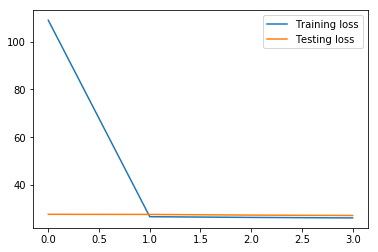

In [137]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend(loc='best')
plt.show();

In [139]:
preds = model.predict(X_test, verbose=1)

9939/9939 [==============================] - 3s 334us/step


In [ ]:
plt.figure(figsize=(15,15))
plt.hist(y_test-preds)

(array([995., 994., 993., 994., 993., 994., 995., 994., 993., 994.]),
 array([   0. ,  993.3, 1986.6, 2979.9, 3973.2, 4966.5, 5959.8, 6953.1,
        7946.4, 8939.7, 9933. ]),
 <a list of 10 Patch objects>)